In [ ]:
%load_ext autoreload
%autoreload 2
import sys

# instead of creating a package using setup.py or building from a docker/singularity file,
# import the sister directory of src code to be called on in notebook.
# This keeps the notebook free from code to only hold visualizations and is easier to test
# It also helps keep the state of variables clean such that cells aren't run out of order with a mysterious state
sys.path.append(".")

In [ ]:
from sklearn.feature_selection import mutual_info_classif as MIC
from comet_ml import Experiment
from comet_ml.integration.pytorch import log_model
from comet_ml import Optimizer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import nn
import os
import datetime as dt
from dateutil.parser import parse
from tqdm import tqdm
import re
import emd
import statistics as st
from multiprocessing import Process

In [ ]:
def col_drop(df):
    df = df.drop(
        columns=[
            "day_of_year",
            "flag",
            "station",
            "latitude",
            "longitude",
            "t2m",
            "sh2",
            "d2m",
            "r2",
            "u10",
            "v10",
            "tp",
            "mslma",
            "orog",
            "tcc",
            "asnow",
            "cape",
            "dswrf",
            "dlwrf",
            "gh",
            "u_total",
            "u_dir",
            "new_tp",
            "lat",
            "lon",
            "elev",
            "tair",
            "ta9m",
            "td",
            "relh",
            "srad",
            "pres",
            "mslp",
            "wspd_sonic",
            "wmax_sonic",
            "wdir_sonic",
            "precip_total",
            "snow_depth",
            "day_of_year",
            "day_of_year_sin",
            "day_of_year_cos",
            "11_nlcd",
            "21_nlcd",
            "22_nlcd",
            "23_nlcd",
            "24_nlcd",
            "31_nlcd",
            "41_nlcd",
            "42_nlcd",
            "43_nlcd",
            "52_nlcd",
            "71_nlcd",
            "81_nlcd",
            "82_nlcd",
            "90_nlcd",
            "95_nlcd",
            "19_aspect",
            "21_aspect",
            "24_aspect",
            "27_aspect",
            "28_aspect",
            "22_aspect",
            "23_aspect",
            "25_aspect",
            "26_aspect",
            "31_aspect",
            "33_aspect",
            "32_aspect",
            "34_aspect",
            "38_aspect",
            "std_elev",
            "variance_elev",
            "skew_elev",
            "med_dist_elev",
        ]
    )
    df = df[df.columns.drop(list(df.filter(regex="time")))]
    df = df[df.columns.drop(list(df.filter(regex="station")))]
    df = df[df.columns.drop(list(df.filter(regex="tair")))]
    df = df[df.columns.drop(list(df.filter(regex="ta9m")))]
    df = df[df.columns.drop(list(df.filter(regex="td")))]
    df = df[df.columns.drop(list(df.filter(regex="relh")))]
    df = df[df.columns.drop(list(df.filter(regex="srad")))]
    df = df[df.columns.drop(list(df.filter(regex="pres")))]
    df = df[df.columns.drop(list(df.filter(regex="wspd")))]
    df = df[df.columns.drop(list(df.filter(regex="wmax")))]
    df = df[df.columns.drop(list(df.filter(regex="wdir")))]
    df = df[df.columns.drop(list(df.filter(regex="precip_total")))]
    df = df[df.columns.drop(list(df.filter(regex="snow_depth")))]
    # df = df[df.columns.drop(list(df.filter(regex="BELM")))]
    # df = df[df.columns.drop(list(df.filter(regex="COHO")))]
    # df = df[df.columns.drop(list(df.filter(regex="DELE")))]
    # df = df[df.columns.drop(list(df.filter(regex="ELMI")))]
    # df = df[df.columns.drop(list(df.filter(regex="GROV")))]
    # df = df[df.columns.drop(list(df.filter(regex="HART")))]
    # df = df[df.columns.drop(list(df.filter(regex="OLEA")))]
    # df = df[df.columns.drop(list(df.filter(regex="RAND")))]

    return df

In [ ]:
def nwp_error(target, station, df):
    vars_dict = {
        "t2m": "tair",
        "mslma": "pres",
    }
    nysm_var = vars_dict.get(target)

    df["target_error"] = df[f"{target}_{station}"] - df[f"{nysm_var}_{station}"]
    return df

In [ ]:
def encode(data, col, max_val, valid_times):
    data["valid_time"] = valid_times
    data = data[data.columns.drop(list(data.filter(regex="day")))]
    data["day_of_year"] = data["valid_time"].dt.dayofyear
    data[col + "_sin"] = np.sin(2 * np.pi * data[col] / max_val).astype(float)
    data[col + "_cos"] = np.cos(2 * np.pi * data[col] / max_val)
    data = data.drop(columns=["valid_time", "day_of_year"]).astype(float)

    return data

In [ ]:
def format_climate_df(data_path):
    """
    Formats a climate data file located at the specified `data_path` into a pandas DataFrame.

    Args:
        data_path (str): The file path for the climate data file.

    Returns:
        pandas.DataFrame: A DataFrame containing the climate data, with the first column renamed to "year".
    """
    raw_index = np.loadtxt(f"{data_path}")
    cl_index = pd.DataFrame(raw_index)
    cl_index = cl_index.rename(columns={0: "year"})
    return cl_index

In [ ]:
def get_clim_indexes(df, valid_times):
    """
    Fetch climate indexes data and add corresponding index values to the input DataFrame.

    This function takes a DataFrame (`df`) containing weather data with a 'valid_time' column representing
    timestamps. It reads climate indexes data from text files in the specified directory and extracts index
    values corresponding to the month and year of each timestamp in the DataFrame. The extracted index values
    are then added to the DataFrame with new columns named after each index.

    Parameters:
    df (pandas.DataFrame): Input DataFrame containing weather data with a 'valid_time' column.

    Returns:
    pandas.DataFrame: The input DataFrame with additional columns for each climate index containing their values.
    """

    clim_df_path = "/home/aevans/nwp_bias/src/correlation/data/indexes/"
    directory = os.listdir(clim_df_path)
    df["valid_time"] = valid_times

    # Loop through each file in the specified directory
    for d in directory:
        if d.endswith(".txt"):
            # Read the climate index data from the file and format it into a DataFrame
            clim_df = format_climate_df(f"{clim_df_path}{d}")
            index_name = d.split(".")[0]

            clim_ind_ls = []
            for t, _ in enumerate(df["valid_time"]):
                time_obj = df["valid_time"].iloc[t]
                dt_object = parse(str(time_obj))
                year = dt_object.strftime("%Y")
                month = dt_object.strftime("%m")
                # Filter the climate DataFrame to get data for the specific year
                df1 = clim_df.loc[clim_df["year"] == int(year)]
                df1 = df1.drop(columns="year")
                row_list = df1.values
                keys = df1.keys()
                key_vals = keys.tolist()

                # Extract the index value corresponding to the month of the timestamp
                the_list = []
                for n, _ in enumerate(key_vals):
                    val1 = key_vals[n]
                    val2 = row_list[0, n]
                    tup = (val1, val2)
                    the_list.append(tup)
                for k, r in the_list:
                    if str(k).zfill(2) == month:
                        clim_ind_ls.append(r)

            # Add the climate index values as a new column in the DataFrame
            df[index_name] = clim_ind_ls

    df = df.drop(columns="valid_time")
    return df

In [ ]:
def normalize_df(df, valid_times):
    print("init normalizer")
    df = col_drop(df)
    the_df = df.dropna()
    for k, r in the_df.items():
        if len(the_df[k].unique()) == 1:
            org_str = str(k)
            my_str = org_str[:-5]
            vals = the_df.filter(regex=my_str)
            vals = vals.loc[0].tolist()
            means = st.mean(vals)
            stdevs = st.pstdev(vals)
            the_df[k] = (the_df[k] - means) / stdevs

            the_df = the_df.fillna(0)
            # |sh2|d2m|r2|u10|v10|tp|mslma|tcc|asnow|cape|dswrf|dlwrf|gh|utotal|u_dir|new_tp
        if re.search(
            "t2m",
            k,
        ):
            ind_val = the_df.columns.get_loc(k)
            x = the_df[k]
            imf = emd.sift.sift(x)
            # the_df = the_df.drop(columns=k)
            for i in range(imf.shape[1]):
                imf_ls = imf[:, i].tolist()
                # Inserting the column at the
                # beginning in the DataFrame
                my_loc = ind_val + i
                the_df.insert(loc=(my_loc), column=f"{k}_imf_{i}", value=imf_ls)

        else:
            means = st.mean(the_df[k])
            stdevs = st.pstdev(the_df[k])
            the_df[k] = (the_df[k] - means) / stdevs

    final_df = the_df.fillna(0)
    print("!!! Dropping Columns !!!")
    final_df = final_df[final_df.columns.drop(list(final_df.filter(regex="latitude")))]
    final_df = final_df[final_df.columns.drop(list(final_df.filter(regex="longitude")))]
    final_df = final_df[final_df.columns.drop(list(final_df.filter(regex="u_total")))]
    final_df = final_df[final_df.columns.drop(list(final_df.filter(regex="mslp")))]
    final_df = final_df[final_df.columns.drop(list(final_df.filter(regex="orog")))]

    print("--- configuring data ---")
    final_df = encode(final_df, "day_of_year", 366, valid_times)
    final_df = get_clim_indexes(final_df, valid_times)
    new_features = list(final_df.columns.difference(["target_error"]))
    print("---normalize successful---")

    return final_df, new_features

In [ ]:
def get_flag(hrrr_df):
    """
    Create a flag column in the input DataFrame indicating consecutive hourly time intervals.

    This function takes a DataFrame containing weather data for different stations, with a 'station' column
    representing the station ID and a 'valid_time' column containing timestamps of the weather data.
    It calculates the time difference between consecutive timestamps for each station and marks it as 'True'
    in a new 'flag' column if the difference is exactly one hour, indicating consecutive hourly time intervals.
    Otherwise, it marks the 'flag' as 'False'.

    Parameters:
    hrrr_df (pandas.DataFrame): Input DataFrame containing weather data for different stations.

    Returns:
    pandas.DataFrame: The input DataFrame with an additional 'flag' column indicating consecutive hourly time intervals.

    Example:
      station           valid_time   flag
    0        1 2023-08-01 00:00:00   True
    1        1 2023-08-01 01:00:00   False
    2        1 2023-08-01 03:00:00   False
    3        2 2023-08-01 08:00:00   True
    4        2 2023-08-01 09:00:00   False
    5        2 2023-08-01 11:00:00   True
    """

    # Get unique station IDs
    stations_ls = hrrr_df["station"].unique()

    # Define a time interval of one hour
    one_hour = dt.timedelta(hours=1)

    # Initialize a list to store flags for each time interval
    flag_ls = []

    # Loop through each station and calculate flags for consecutive hourly time intervals
    for station in stations_ls:
        # Filter DataFrame for the current station
        df = hrrr_df[hrrr_df["station"] == station]

        # Get the list of valid_time timestamps for the current station
        time_ls = df["valid_time"].tolist()

        # Compare each timestamp with the next one to determine consecutive intervals
        for now, then in zip(time_ls, time_ls[1:]):
            if now + one_hour == then:
                flag_ls.append(True)
            else:
                flag_ls.append(False)

    # Append an extra True to indicate the last time interval (since it has no next timestamp for comparison)
    flag_ls.append(True)

    # Add the 'flag' column to the DataFrame
    hrrr_df["flag"] = flag_ls

    return hrrr_df

In [10]:
df = pd.read_parquet(
    "/home/aevans/nwp_bias/src/machine_learning/data/clean_parquets/nysm_cats/cleaned_rough_lstm_nysmcat_Western Plateau.parquet"
)
df = df.dropna()
valid_times = df["valid_time"].tolist()
df = get_flag(df)
df = nwp_error("t2m", "ADDI", df)
the_df, new_features = normalize_df(df, valid_times)

/home/aevans/miniconda3/lib/python3.9/site-packages/emd/support.py:228: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  out_args[idx] = out_args[idx][:, np.newaxis]
/home/aevans/miniconda3/lib/python3.9/site-packages/emd/support.py:228: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  out_args[idx] = out_args[idx][:, np.newaxis]
/home/aevans/miniconda3/lib/python3.9/site-packages/emd/support.py:228: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  out_args[idx] = out_args[idx][:, np.newaxis]
/home/aevans/miniconda3/lib/python3.9/site-packages/emd/support.py:228: FutureWarning: Support fo

!!! Dropping Columns !!!
--- configuring data ---


/tmp/tmp.NQreiNevbA/ipykernel_1726564/829324959.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["day_of_year"] = data["valid_time"].dt.dayofyear
/tmp/tmp.NQreiNevbA/ipykernel_1726564/829324959.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col + "_sin"] = np.sin(2 * np.pi * data[col] / max_val).astype(float)
/tmp/tmp.NQreiNevbA/ipykernel_1726564/829324959.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

---normalize successful---


In [11]:
the_df.keys()

Index(['t2m_ADDI_imf_0', 't2m_ADDI_imf_1', 't2m_ADDI_imf_2', 't2m_ADDI_imf_3',
       't2m_ADDI_imf_4', 't2m_ADDI_imf_5', 't2m_ADDI_imf_6', 't2m_ADDI_imf_7',
       't2m_ADDI_imf_8', 't2m_ADDI_imf_9',
       ...
       'day_of_year_cos', 'amo', 'amoc', 'enso4', 'enso_1_2', 'pna', 'enso3',
       'ao', 'pdo', 'nao'],
      dtype='object', length=560)

In [12]:
from sklearn import preprocessing
from sklearn import utils
from sklearn.datasets import load_breast_cancer as LBC

cancer = LBC()
X = cancer["data"]
y = cancer["target"]

print(X)
print(y)

[[1.799e+01 1.038e+01 1.228e+02 ... 2.654e-01 4.601e-01 1.189e-01]
 [2.057e+01 1.777e+01 1.329e+02 ... 1.860e-01 2.750e-01 8.902e-02]
 [1.969e+01 2.125e+01 1.300e+02 ... 2.430e-01 3.613e-01 8.758e-02]
 ...
 [1.660e+01 2.808e+01 1.083e+02 ... 1.418e-01 2.218e-01 7.820e-02]
 [2.060e+01 2.933e+01 1.401e+02 ... 2.650e-01 4.087e-01 1.240e-01]
 [7.760e+00 2.454e+01 4.792e+01 ... 0.000e+00 2.871e-01 7.039e-02]]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 1 0 1 1 1 1 1 0 0 1 0 0 1 1 1 1 0 1 0 0 1 1 1 1 0 1 0 0
 1 0 1 0 0 1 1 1 0 0 1 0 0 0 1 1 1 0 1 1 0 0 1 1 1 0 0 1 1 1 1 0 1 1 0 1 1
 1 1 1 1 1 1 0 0 0 1 0 0 1 1 1 0 0 1 0 1 0 0 1 0 0 1 1 0 1 1 0 1 1 1 1 0 1
 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0 1 0 1 1 0 0 1 1 0 0 1 1 1 1 0 1 1 0 0 0 1 0
 1 0 1 1 1 0 1 1 0 0 1 0 0 0 0 1 0 0 0 1 0 1 0 1 1 0 1 0 0 0 0 1 1 0 0 1 1
 1 0 1 1 1 1 1 0 0 1 1 0 1 1 0 0 1 0 1 1 1 1 0 1 1 1 1 1 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 1 1 1 1 1 0 1 0 1 1 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 

In [13]:
X = the_df.loc[:, the_df.columns != "target_error"]
y = the_df["target_error"]
# convert y values to categorical values
lab = preprocessing.LabelEncoder()
y_transformed = lab.fit_transform(y)
print(X)
print(y_transformed)

       t2m_ADDI_imf_0  t2m_ADDI_imf_1  t2m_ADDI_imf_2  t2m_ADDI_imf_3  \
0            0.170504        2.071257        0.130187       -0.666658   
1            0.244174        2.082879       -0.061888       -0.408810   
2            0.004027        1.874030       -0.173222       -0.102947   
3           -0.180427        1.485543       -0.209059        0.245777   
4           -0.122428        0.967830       -0.178884        0.631789   
...               ...             ...             ...             ...   
22486        0.696081        0.070036        2.386693        4.788614   
22487       -0.064552       -0.274218        2.463726        4.724536   
22488       -0.505682       -0.542027        2.384501        4.673407   
22489       -0.747992       -0.622066        2.158247        4.634797   
22490       -0.873534       -0.405402        1.796787        4.608038   

       t2m_ADDI_imf_4  t2m_ADDI_imf_5  t2m_ADDI_imf_6  t2m_ADDI_imf_7  \
0            0.677416       -7.863977       -4.560

In [14]:
X

,t2m_ADDI_imf_0,t2m_ADDI_imf_1,t2m_ADDI_imf_2,t2m_ADDI_imf_3,t2m_ADDI_imf_4,t2m_ADDI_imf_5,t2m_ADDI_imf_6,t2m_ADDI_imf_7,t2m_ADDI_imf_8,t2m_ADDI_imf_9,...,day_of_year_cos,amo,amoc,enso4,enso_1_2,pna,enso3,ao,pdo,nao
0,0.170504,2.071257,0.130187,-0.666658,0.677416,-7.863977,-4.560570,-8.645410,0.108044,-0.619988,...,0.999853,0.150,2.12,-0.44,-1.12,-0.14,-1.18,-0.281,0.7,1.17
1,0.244174,2.082879,-0.061888,-0.408810,0.544474,-7.810390,-4.553889,-8.643074,0.107538,-0.619703,...,0.999853,0.150,2.12,-0.44,-1.12,-0.14,-1.18,-0.281,0.7,1.17
2,0.004027,1.874030,-0.173222,-0.102947,0.414537,-7.755222,-4.547154,-8.640726,0.107033,-0.619418,...,0.999853,0.150,2.12,-0.44,-1.12,-0.14,-1.18,-0.281,0.7,1.17
3,-0.180427,1.485543,-0.209059,0.245777,0.287712,-7.698499,-4.540365,-8.638367,0.106527,-0.619133,...,0.999853,0.150,2.12,-0.44,-1.12,-0.14,-1.18,-0.281,0.7,1.17
4,-0.122428,0.967830,-0.178884,0.631789,0.164107,-7.640243,-4.533523,-8.635997,0.106022,-0.618847,...,0.999853,0.150,2.12,-0.44,-1.12,-0.14,-1.18,-0.281,0.7,1.17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22486,0.696081,0.070036,2.386693,4.788614,7.204360,1.153287,-5.228794,-0.442361,0.515221,0.342848,...,0.999853,0.218,1.61,-0.84,-0.46,-0.96,-0.81,-2.719,-9.9,-0.22
22487,-0.064552,-0.274218,2.463726,4.724536,7.261288,1.149547,-5.227474,-0.443623,0.515045,0.342924,...,0.999853,0.218,1.61,-0.84,-0.46,-0.96,-0.81,-2.719,-9.9,-0.22
22488,-0.505682,-0.542027,2.384501,4.673407,7.315747,1.145445,-5.226124,-0.444877,0.514868,0.343000,...,0.999853,0.218,1.61,-0.84,-0.46,-0.96,-0.81,-2.719,-9.9,-0.22
22489,-0.747992,-0.622066,2.158247,4.634797,7.367688,1.140980,-5.224746,-0.446122,0.514691,0.343076,...,0.999853,0.218,1.61,-0.84,-0.46,-0.96,-0.81,-2.719,-9.9,-0.22


In [15]:
mi_score = MIC(X, y_transformed)
print(mi_score)

[0.00000000e+00 1.25144751e-01 0.00000000e+00 4.13128677e-02
 1.86799749e-01 0.00000000e+00 2.92804769e-02 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 8.02175635e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
 6.63033345e-01 5.03302982e-01 1.69785865e-01 5.92154390e-01
 4.98015865e-01 0.00000000e+00 0.00000000e+00 5.83697143e-02
 0.00000000e+00 8.98321546e-01 8.46233233e-01 4.76919518e-01
 8.45152982e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.65233828e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 2.22881094e-01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.92742265e-02 2.03019062e-02 0.00000000e+00 0.00000000e+00
 3.41810242e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.15377624e-01 2.02424280e-01 0.00000000e+00
 2.83055774e-01 5.299772

In [16]:
y_transformed

array([5460, 4203, 3256, ..., 4943, 4778, 8520])

In [17]:
len(mi_score)

559

In [18]:
df = pd.DataFrame()
df["feature"] = new_features
df["mi_score"] = mi_score

In [19]:
df = df.sort_values(by="mi_score", ascending=False)

In [20]:
df

,feature,mi_score
445,t2m_DELE_imf_4,1.884604
325,gh_COHO,1.760509
141,31_nlcd_HART,1.728448
506,tcc_BELM,1.577672
446,t2m_DELE_imf_5,1.546178
...,...,...
239,82_nlcd_GROV,0.000000
236,82_nlcd_COHO,0.000000
235,82_nlcd_BELM,0.000000
233,81_nlcd_RAND,0.000000


In [21]:
a_df = df[df["mi_score"] > 0.2]
b_df = df[df["mi_score"] <= 0.2]

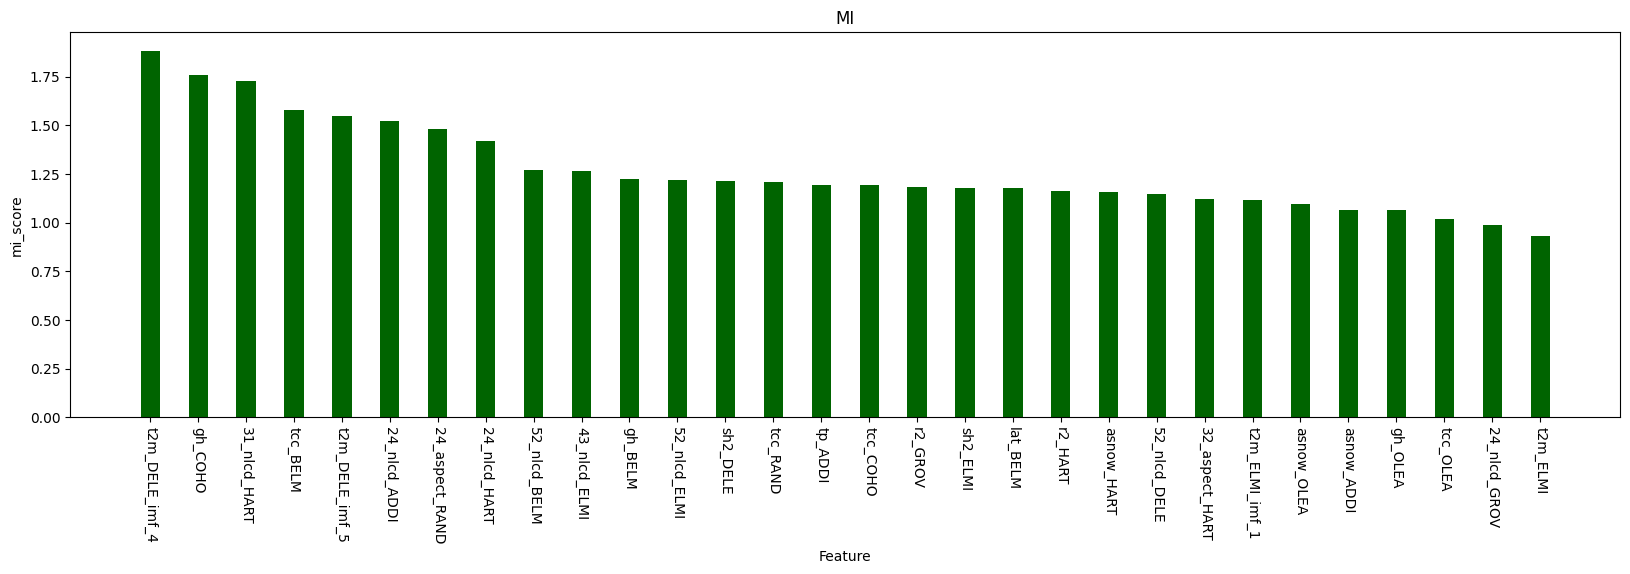

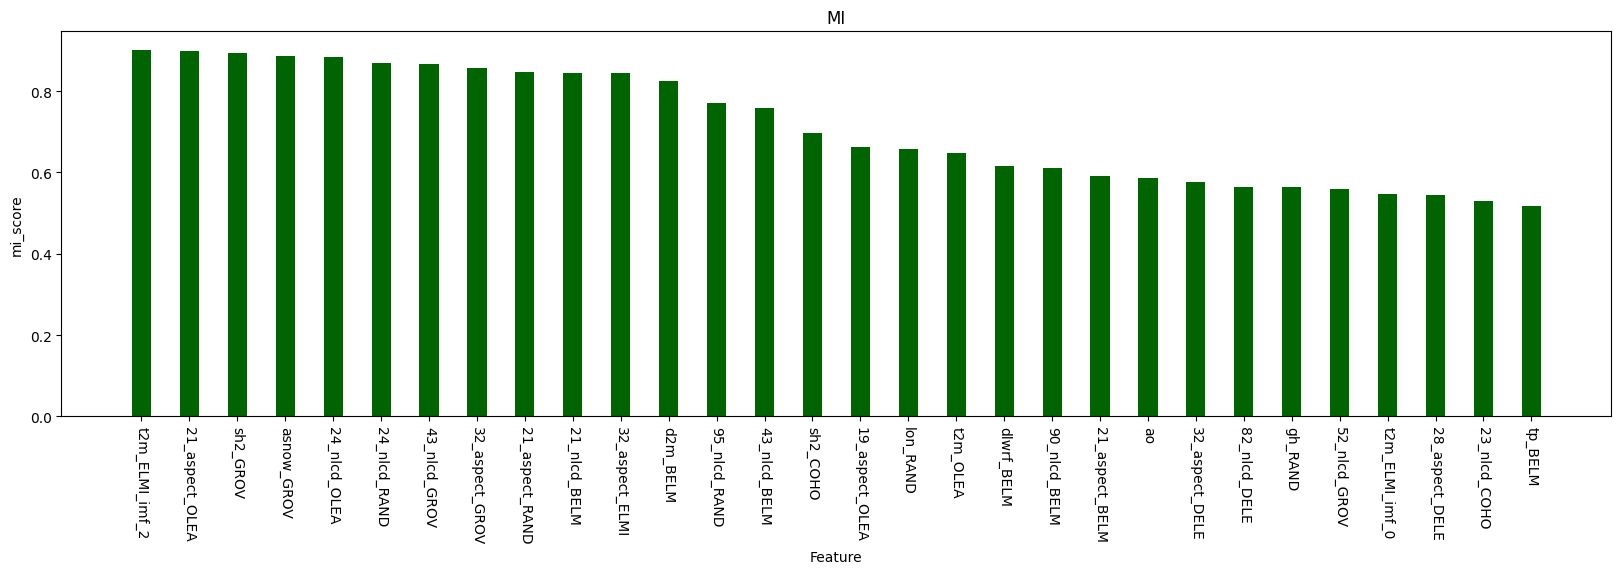

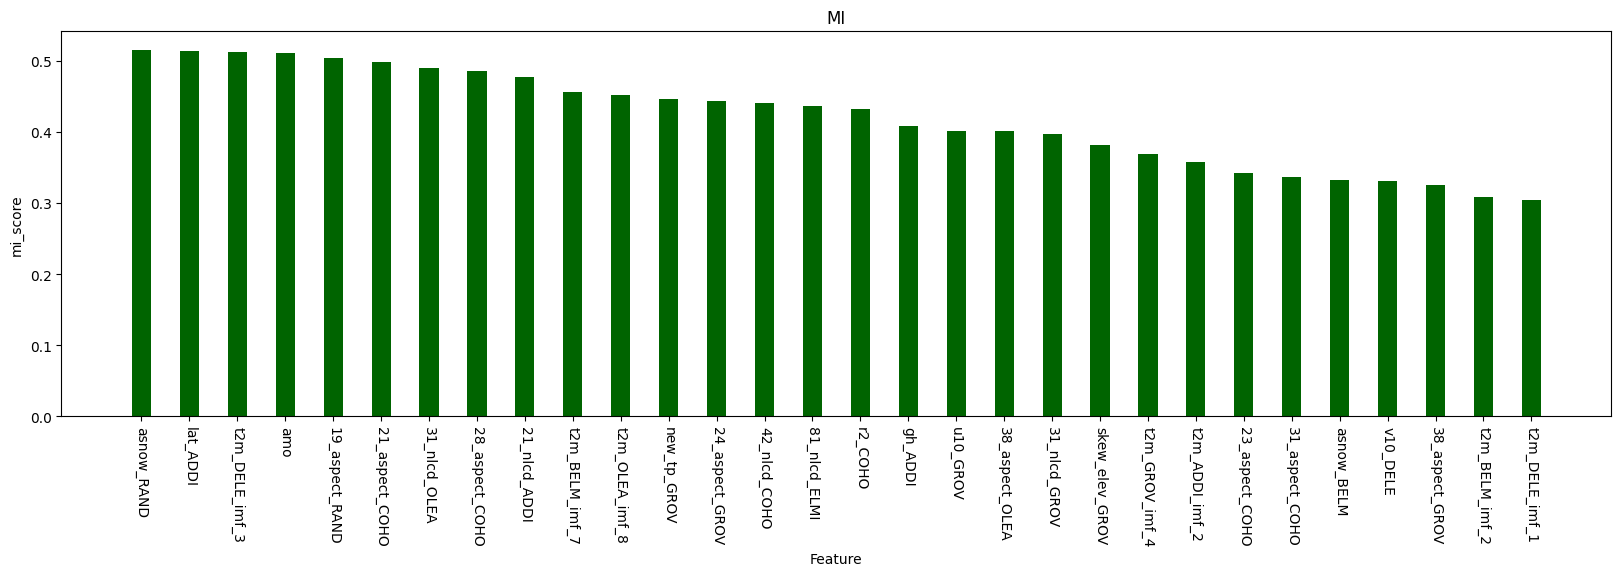

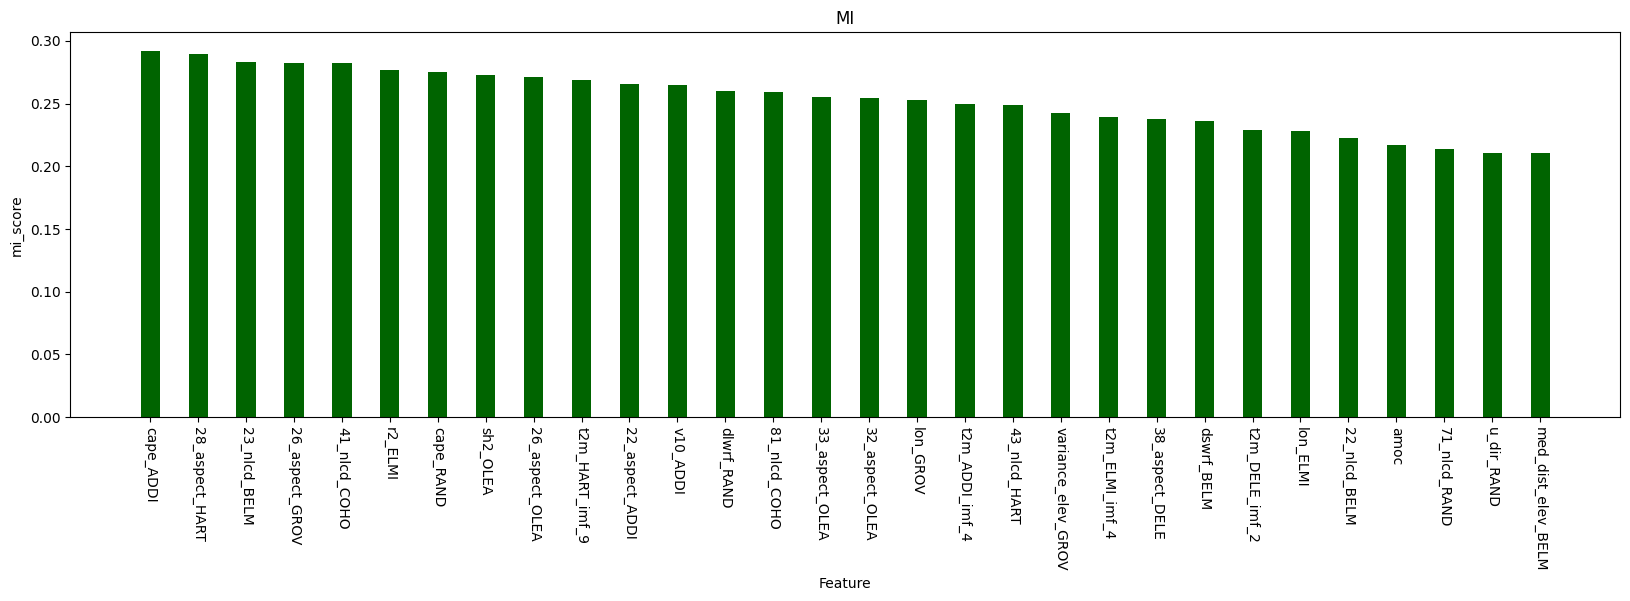

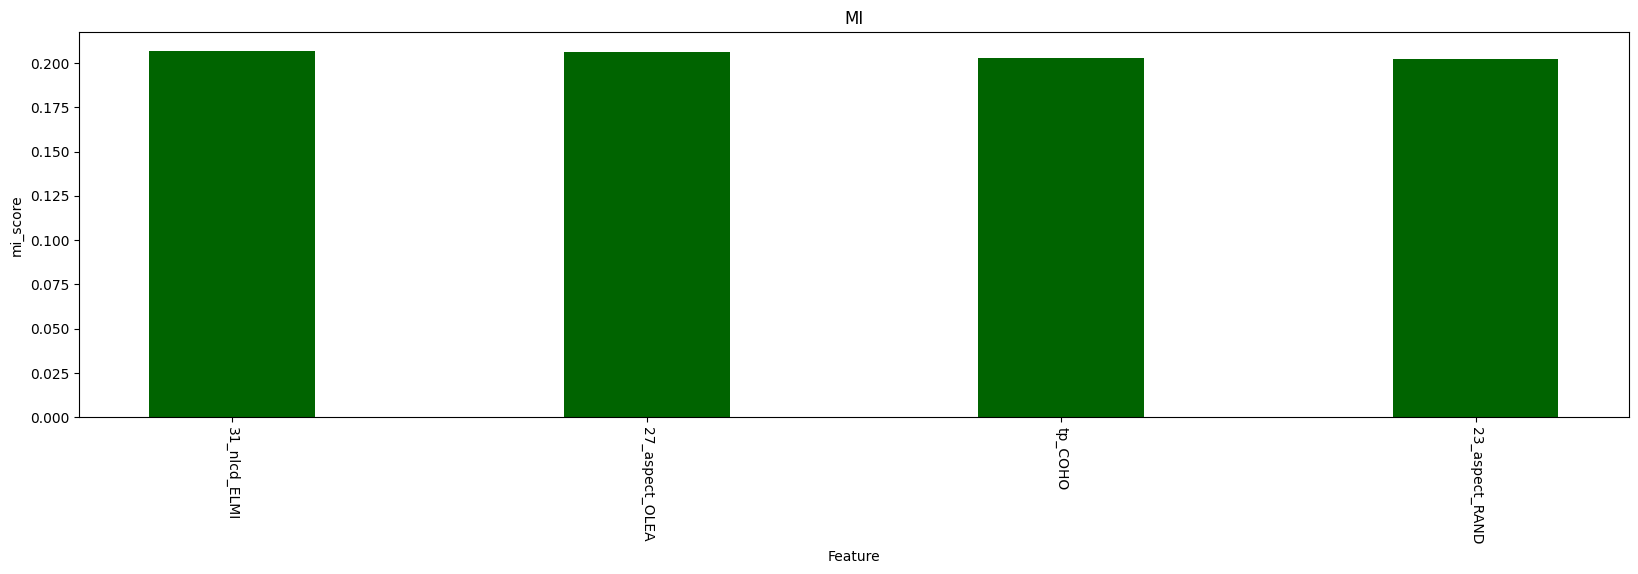

In [22]:
b = 0
e = 30
for i in np.arange(0, len(a_df["feature"]), 30):
    fig = plt.figure(figsize=(20, 5))

    # creating the bar plot
    plt.bar(
        a_df["feature"].iloc[b:e],
        a_df["mi_score"].iloc[b:e],
        color="darkgreen",
        width=0.4,
    )

    plt.xlabel("Feature")
    plt.xticks(rotation=270)
    plt.ylabel("mi_score")
    plt.title("MI")
    plt.show()
    b += 30
    e += 30

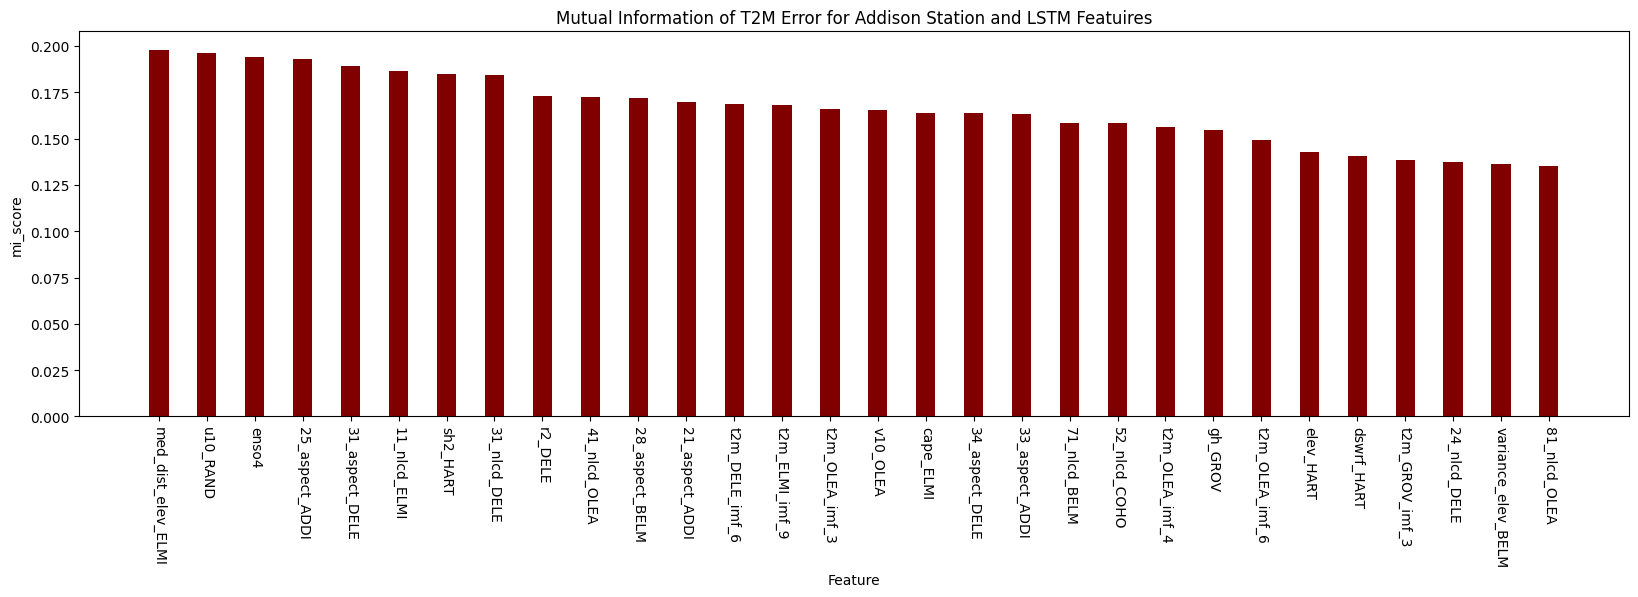

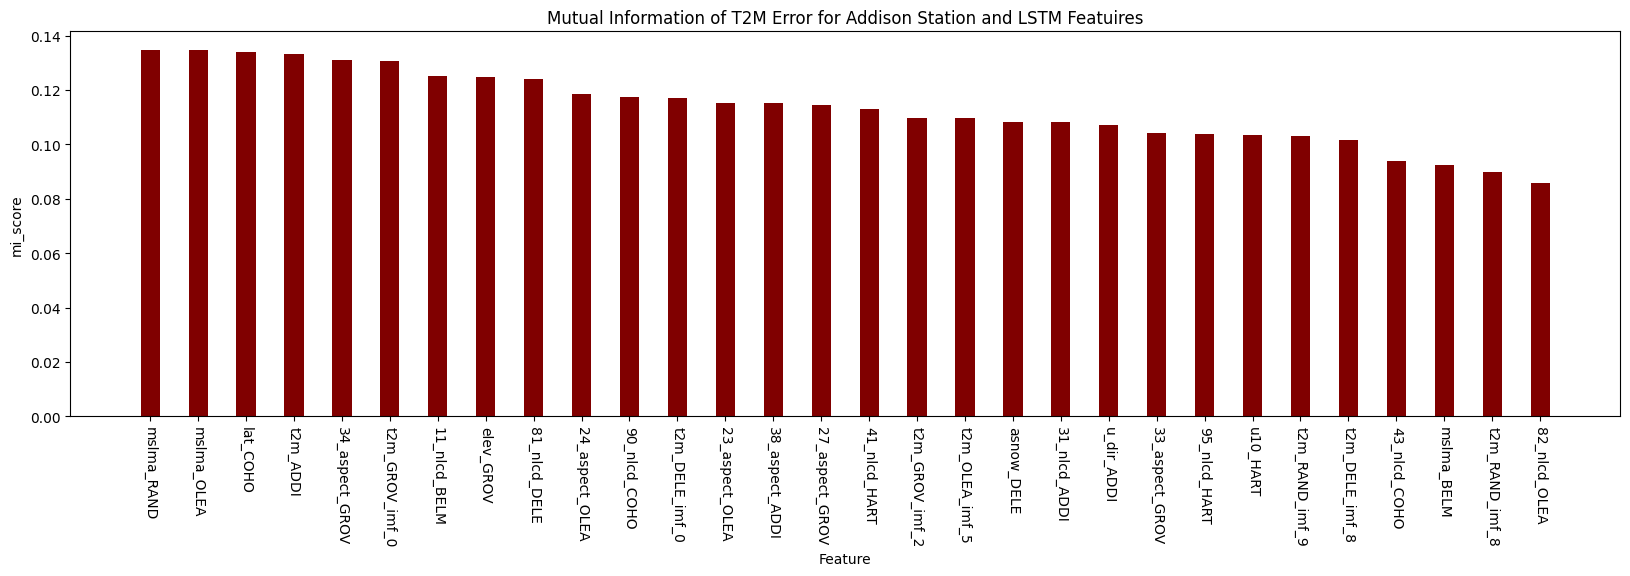

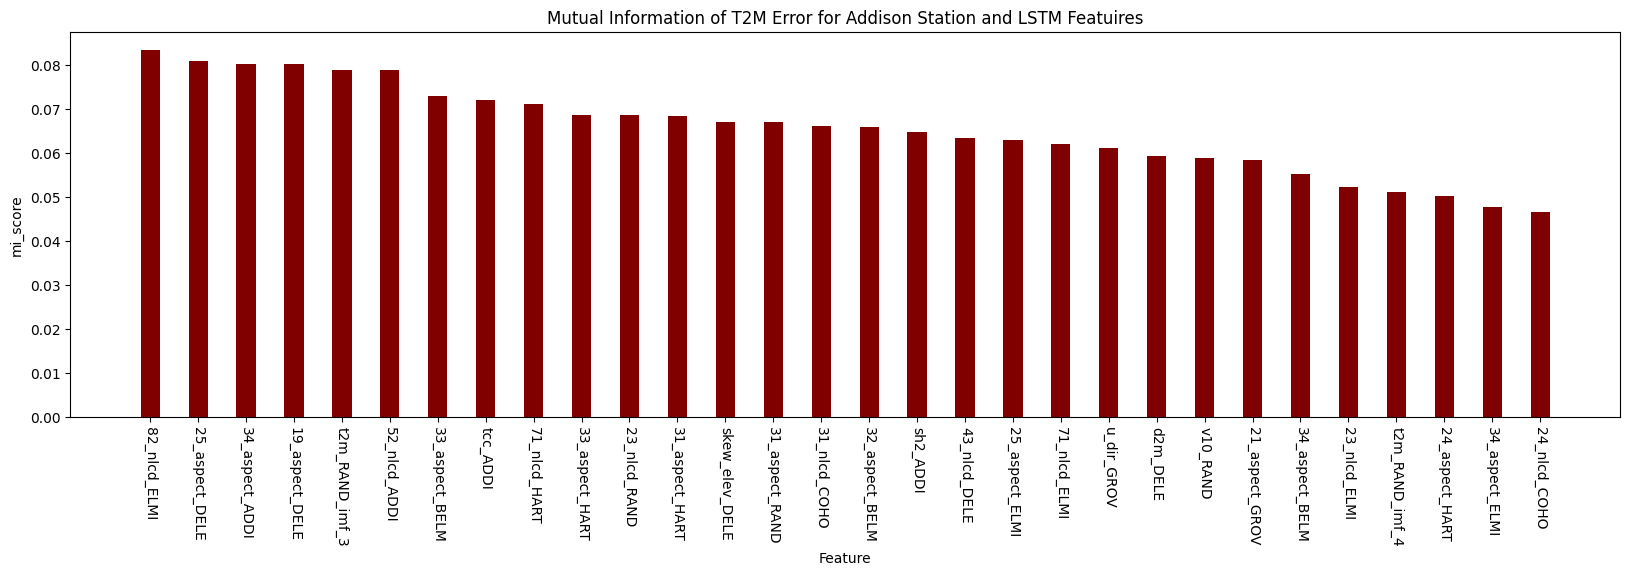

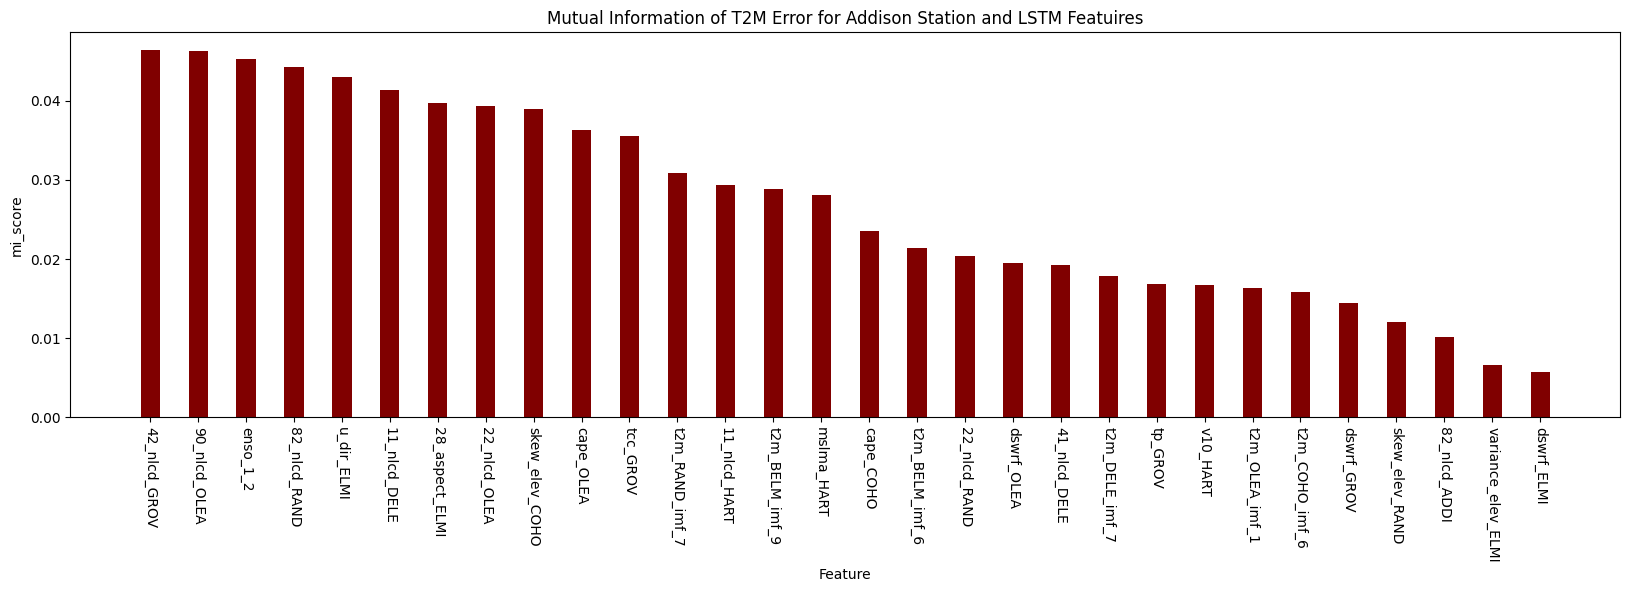

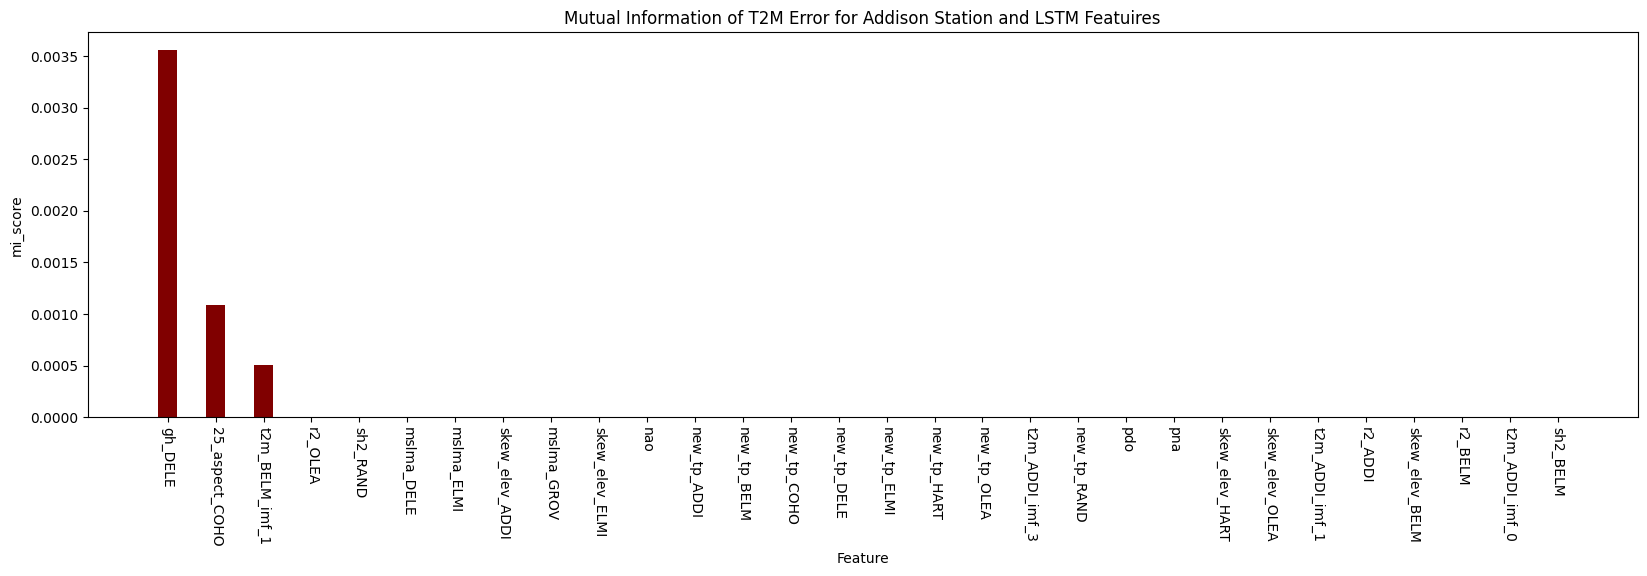

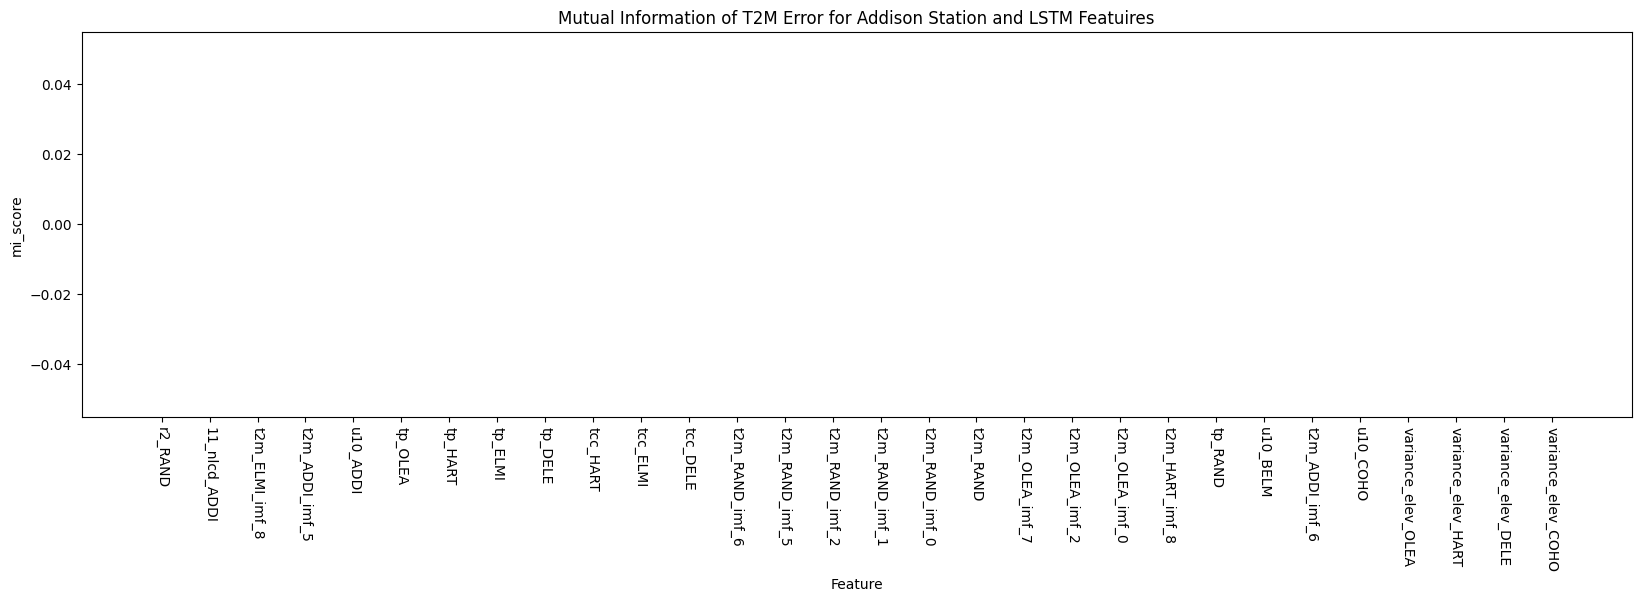

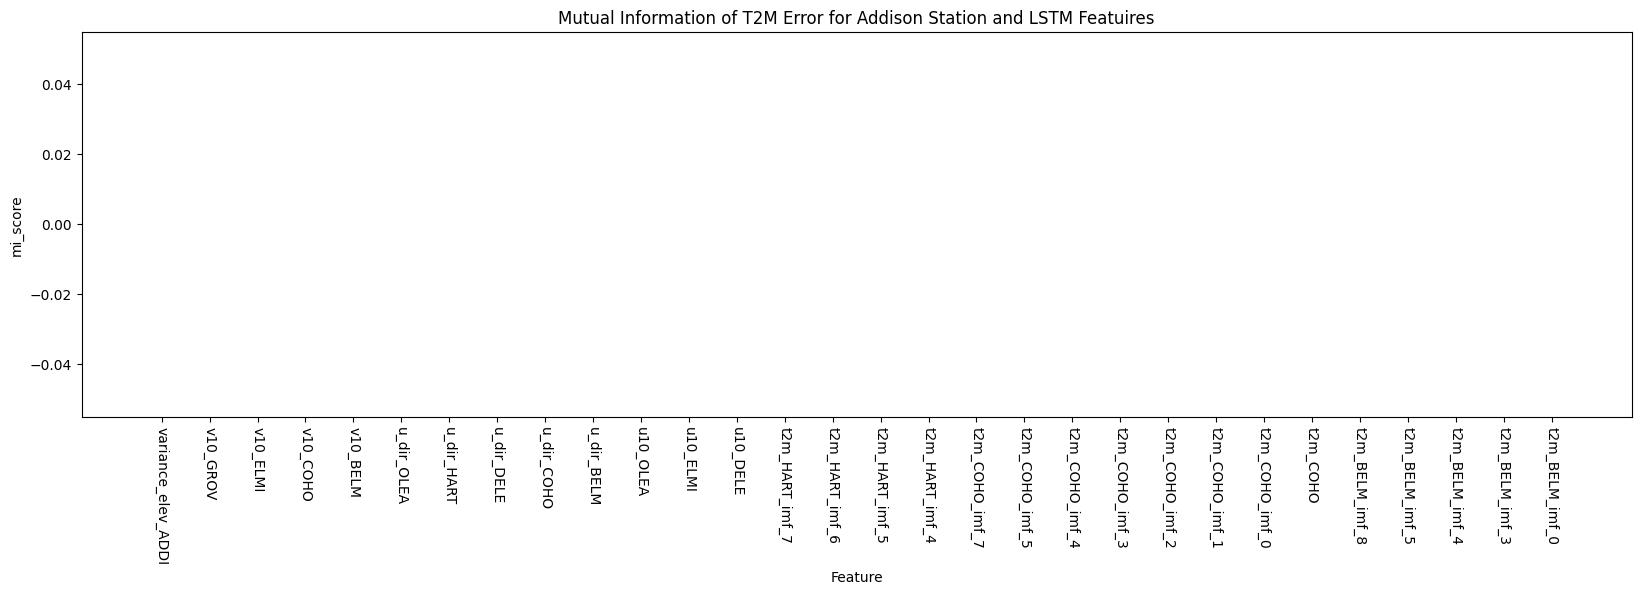

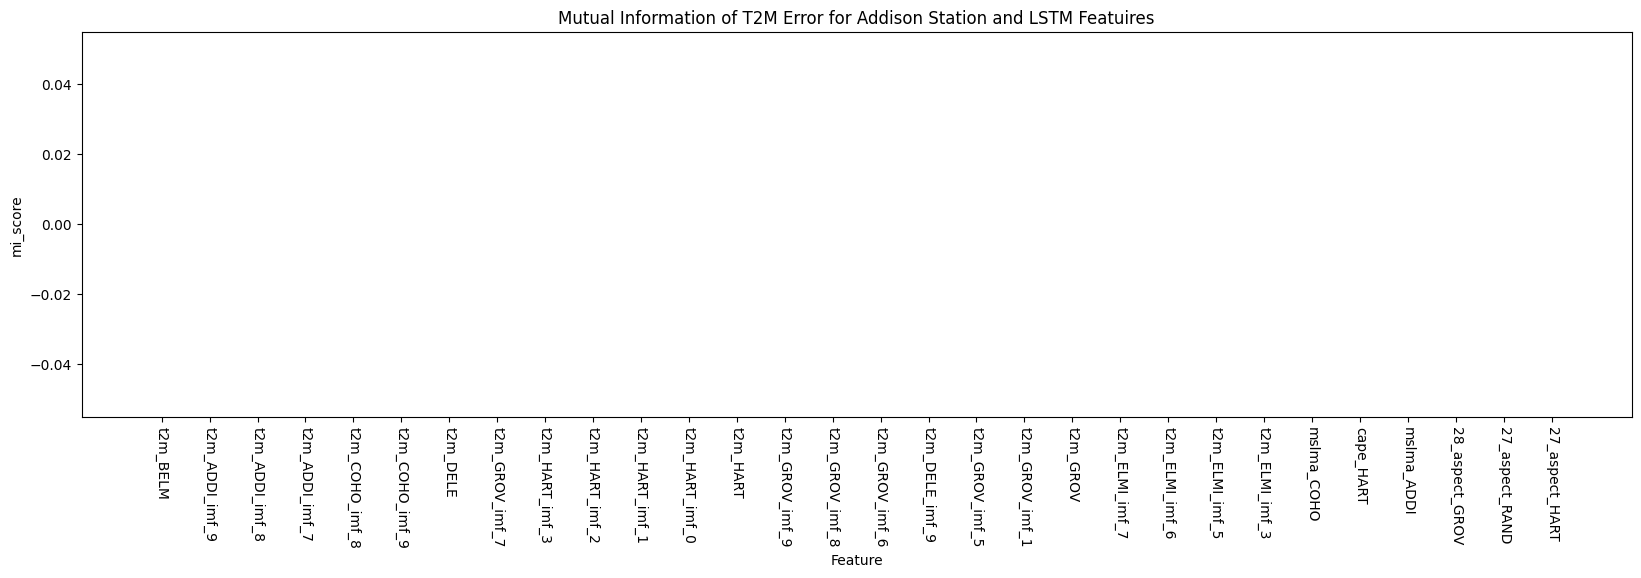

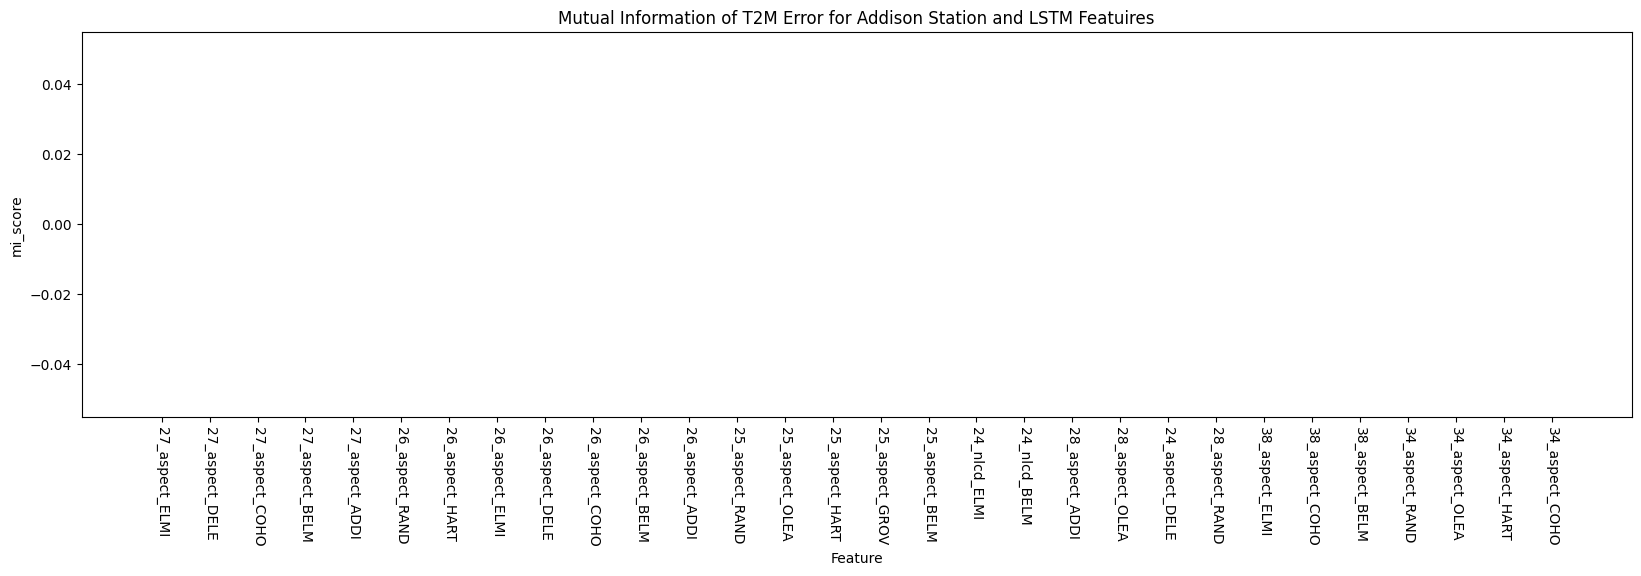

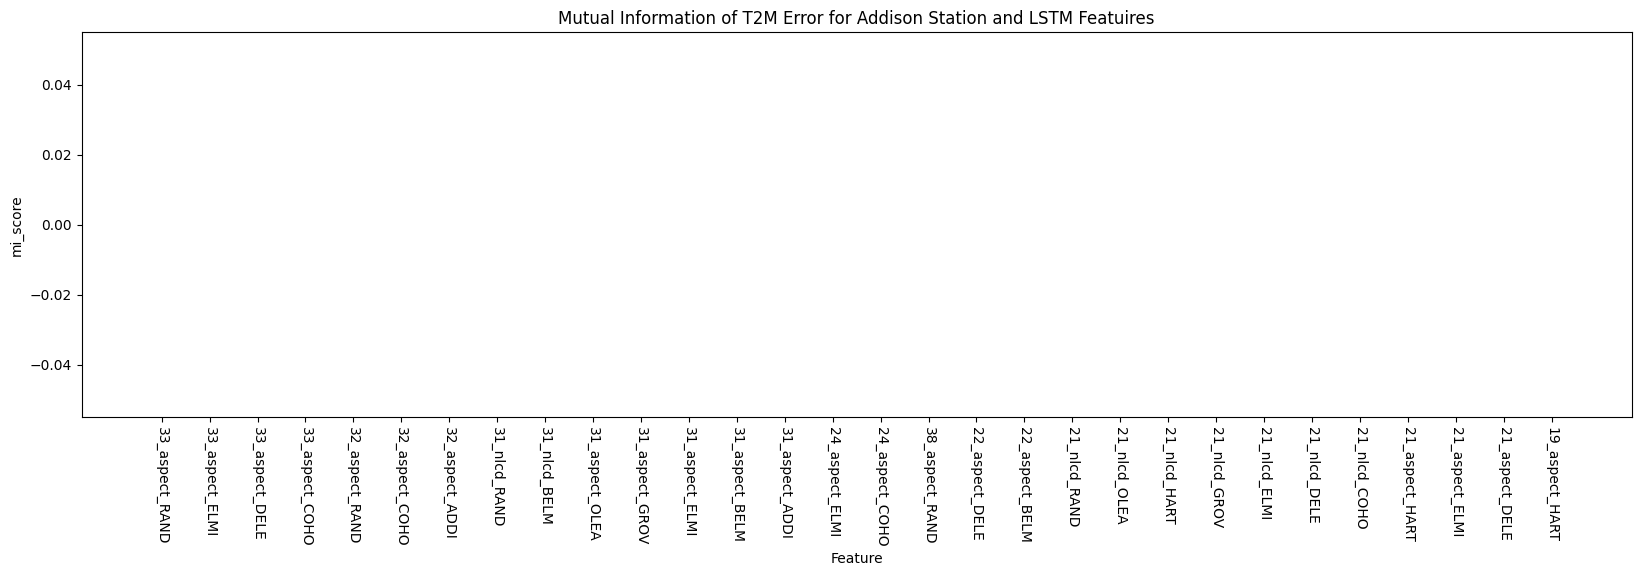

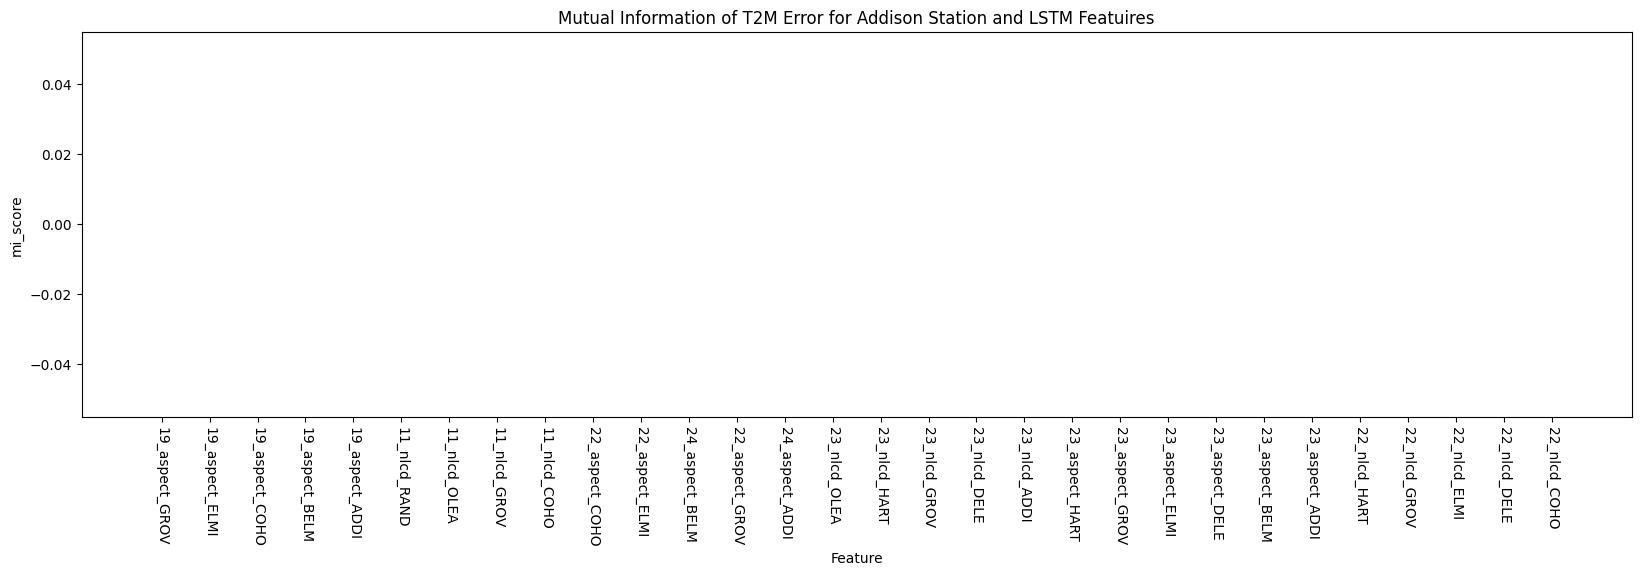

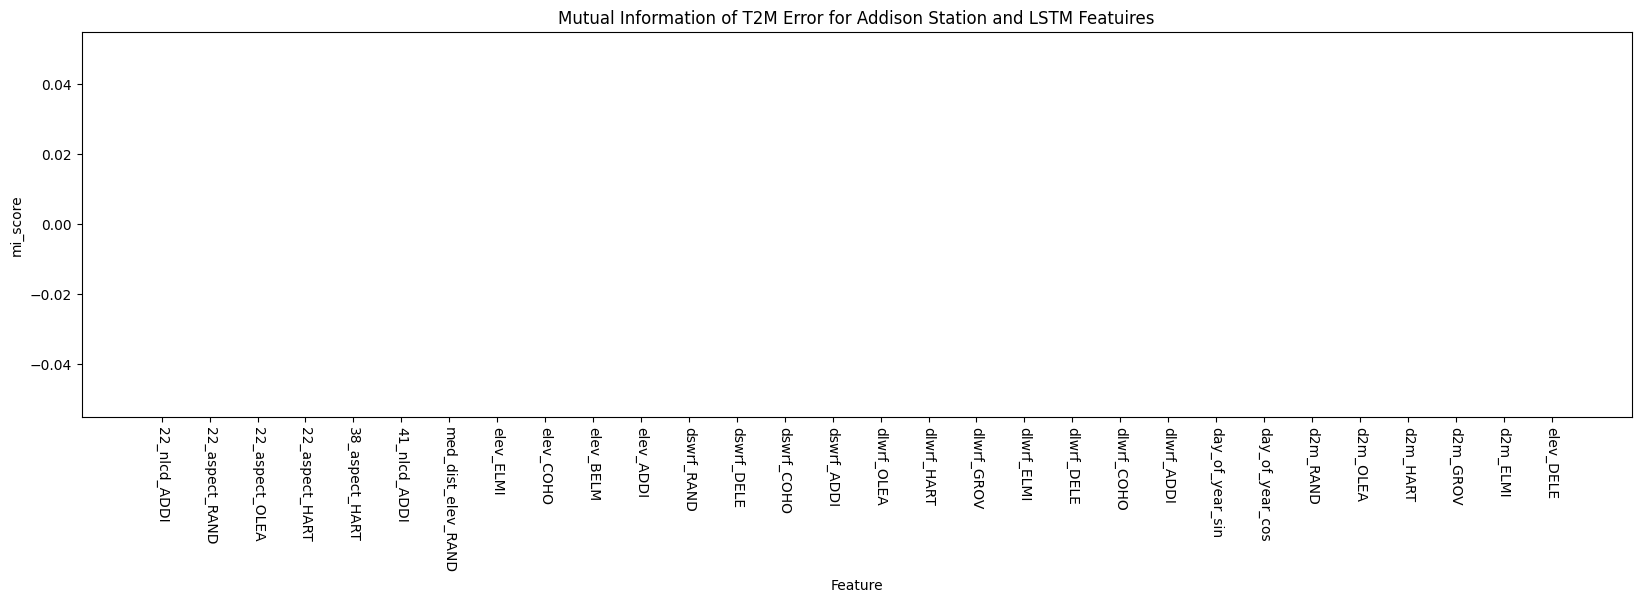

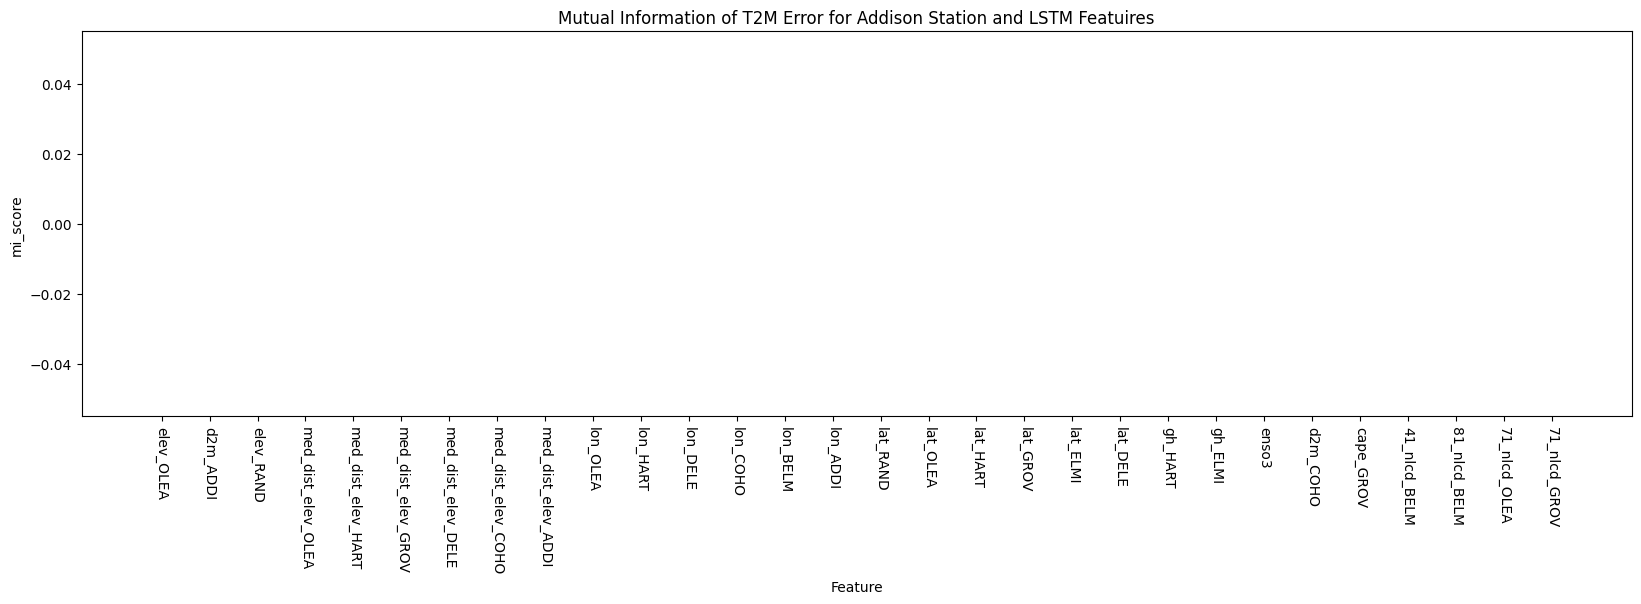

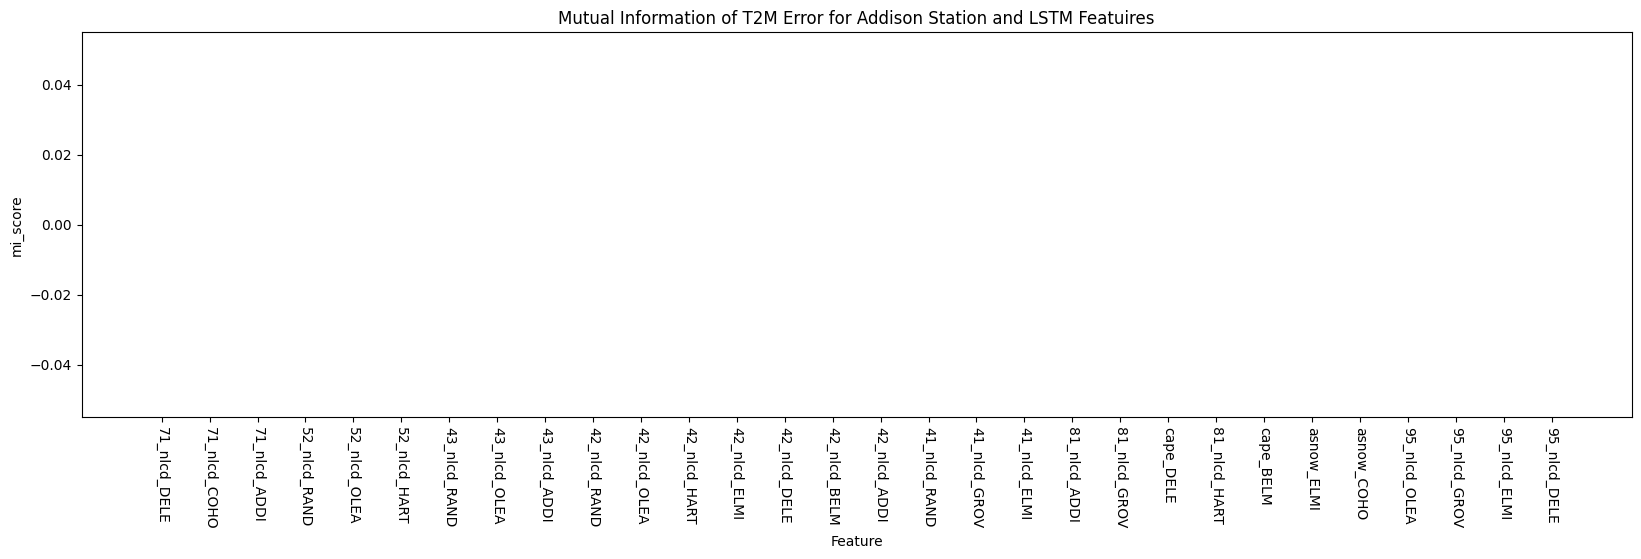

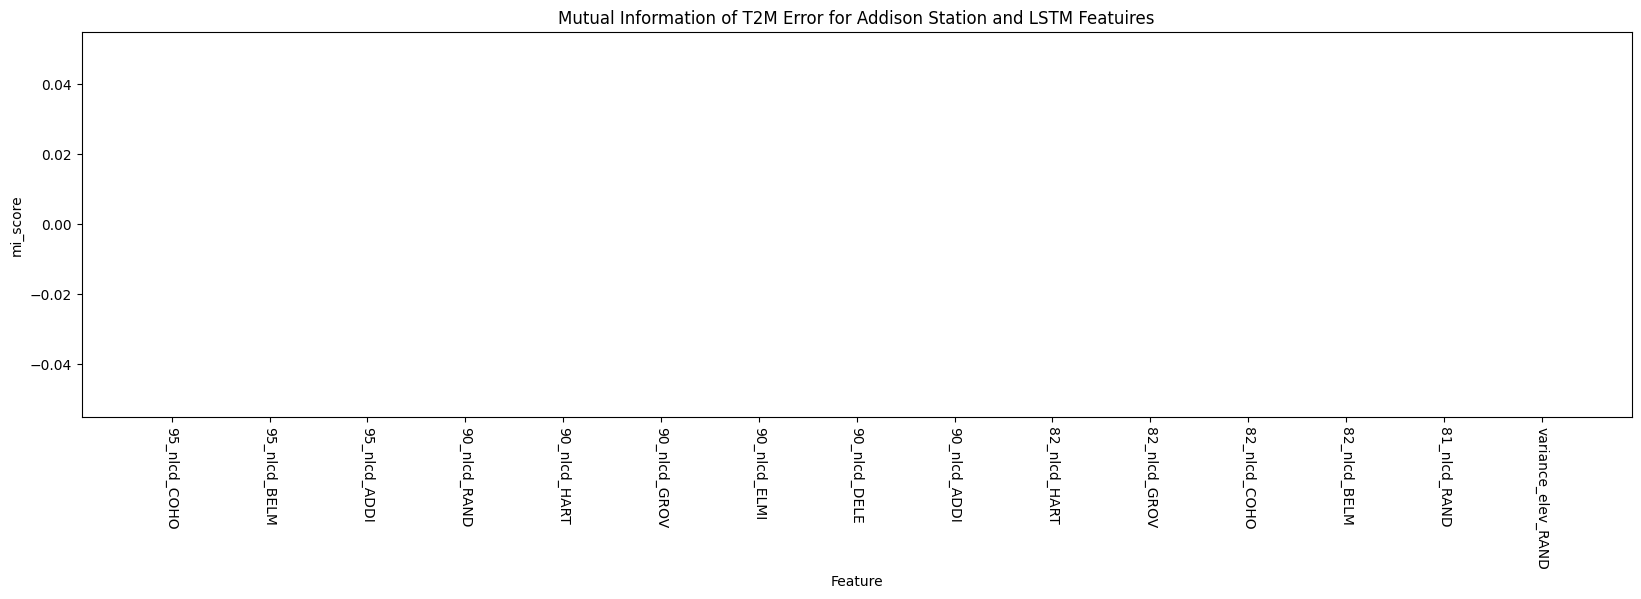

In [23]:
b = 0
e = 30
for i in np.arange(0, len(b_df["feature"]), 30):
    fig = plt.figure(figsize=(20, 5))

    # creating the bar plot
    plt.bar(
        b_df["feature"].iloc[b:e], b_df["mi_score"].iloc[b:e], color="maroon", width=0.4
    )

    plt.xlabel("Feature")
    plt.xticks(rotation=270)
    plt.ylabel("mi_score")
    plt.title("Mutual Information of T2M Error for Addison Station and LSTM Featuires")
    plt.show()
    b += 30
    e += 30

In [37]:
df1 = pd.read_csv(
    "/home/aevans/nwp_bias/src/machine_learning/data/lstm_feature_weights_western_plateau_0.005_100.csv"
)
df2 = pd.read_csv(
    "/home/aevans/nwp_bias/src/machine_learning/data/lstm_feature_weights_western_plateau_3e-05_150.csv"
)
df3 = pd.read_csv(
    "/home/aevans/nwp_bias/src/machine_learning/data/lstm_feature_weights_western_plateau_5e-05_300.csv"
)
df4 = pd.read_csv(
    "/home/aevans/nwp_bias/src/machine_learning/data/lstm_feature_weights_western_plateau_5e-07_500.csv"
)

In [38]:
merged = df1.merge(df2, on="feature")
merged = merged.merge(df3, on="feature")
merged = merged.merge(df4, on="feature")

/tmp/tmp.NQreiNevbA/ipykernel_1726564/1436343621.py:3: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Unnamed: 0_x'} in the result is deprecated and will raise a MergeError in a future version.
  merged = merged.merge(df4, on='feature')


In [39]:
feature_col = merged["feature"].tolist()
merged = merged.drop(
    columns=["feature", "Unnamed: 0_x", "Unnamed: 0_y", "Unnamed: 0_x", "Unnamed: 0_y"]
)
merged["average"] = 0

In [40]:
for i, _ in enumerate(merged["trial --100_0.005"]):
    summed = (
        merged["trial --100_0.005"].iloc[i]
        + merged["trial --150_3e-05"].iloc[i]
        + merged["trial --300_5e-05"].iloc[i]
        + merged["trial --300_5e-05"].iloc[i]
        + merged["trial --500_5e-07"].iloc[i]
    )
    average = summed / 4
    average_mod = average**10
    merged["average"].iloc[i] = average_mod

/tmp/tmp.NQreiNevbA/ipykernel_1726564/2051347839.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged['average'].iloc[i] = average_mod


In [41]:
merged["feature"] = feature_col

In [43]:
merged = merged.sort_values(by="average", ascending=False)

In [44]:
merged

,trial --100_0.005,trial --150_3e-05,trial --300_5e-05,trial --500_5e-07,average,feature
0,1.531708,1.098729,1.008043,1.009792,31.969490,11_nlcd_ADDI
15,1.531708,1.098729,1.008043,1.009792,31.969490,31_nlcd_ADDI
27,1.531708,1.098729,1.008043,1.009792,31.969490,90_nlcd_ADDI
26,1.531708,1.098729,1.008043,1.009792,31.969490,82_nlcd_ADDI
25,1.531708,1.098729,1.008043,1.009792,31.969490,81_nlcd_ADDI
...,...,...,...,...,...,...
62,1.232871,1.088308,0.969607,1.022751,16.155669,t2m_ADDI_imf_7
58,1.186435,1.098317,0.980532,1.015536,15.501471,t2m_ADDI_imf_3
67,1.160505,1.101513,0.984615,1.019188,15.182869,u10_ADDI
63,1.160967,1.069821,0.988155,1.020237,14.527904,t2m_ADDI_imf_8


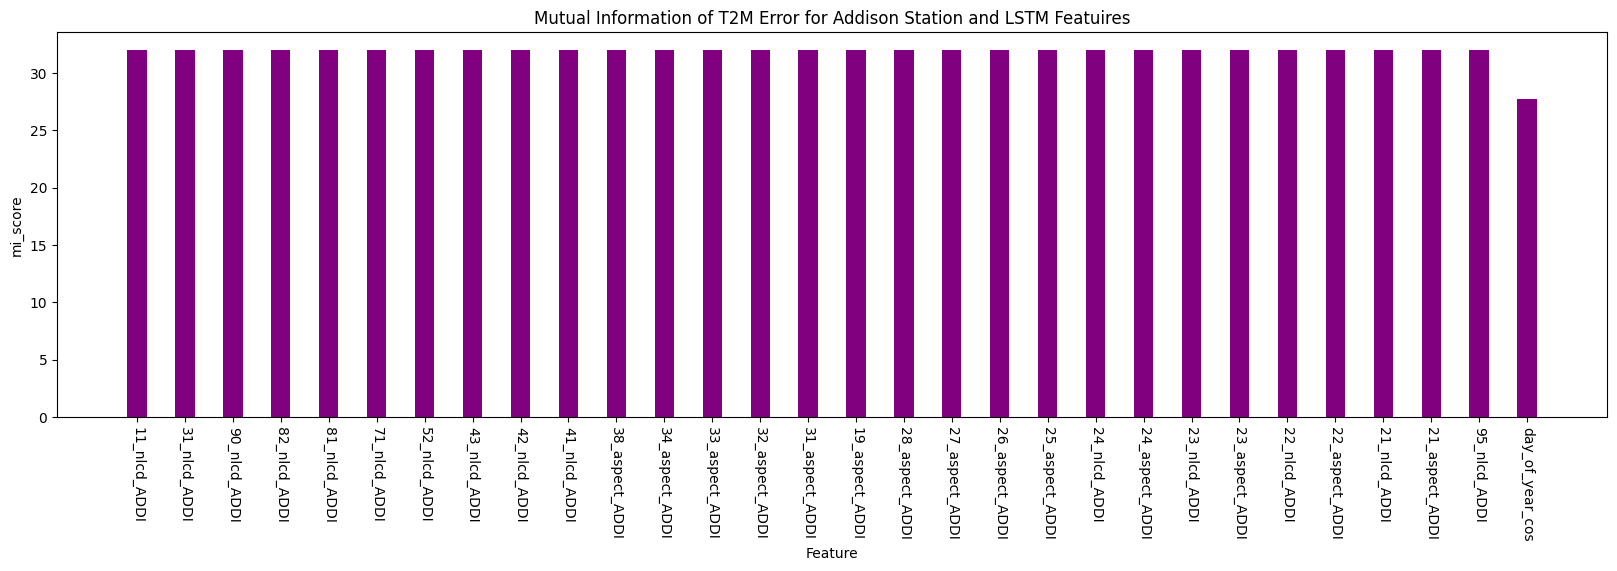

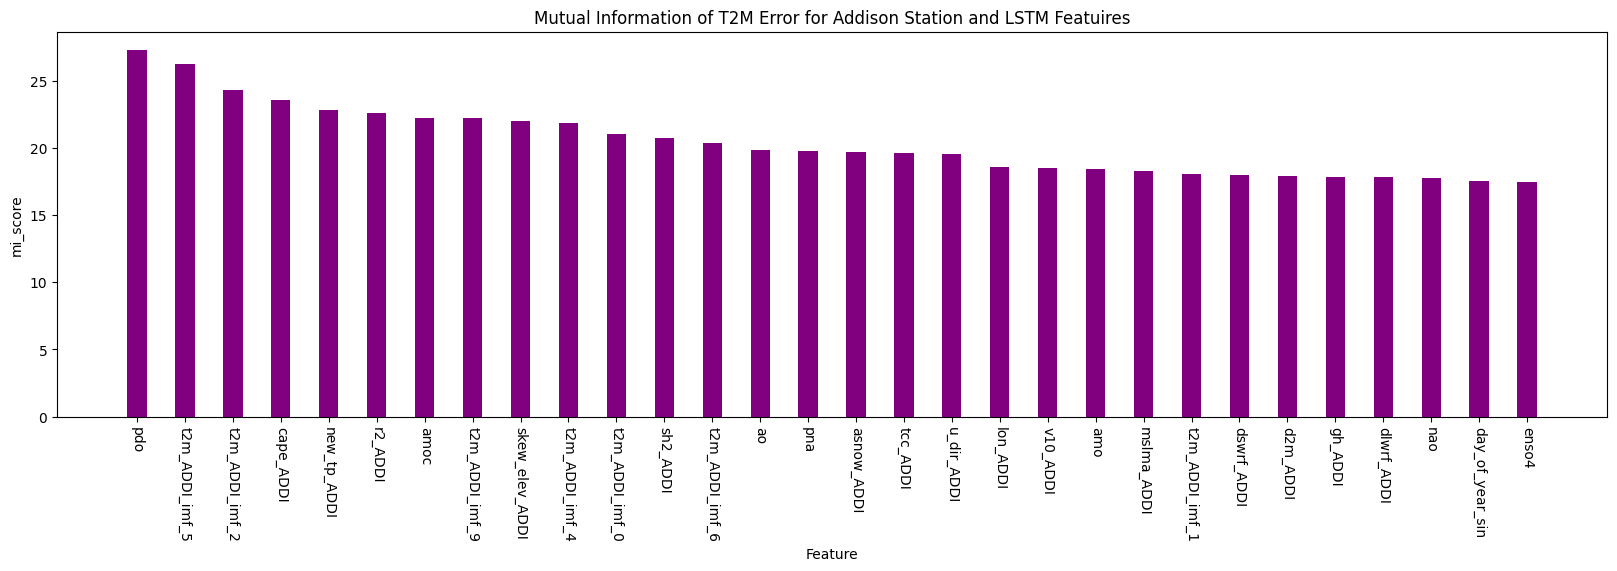

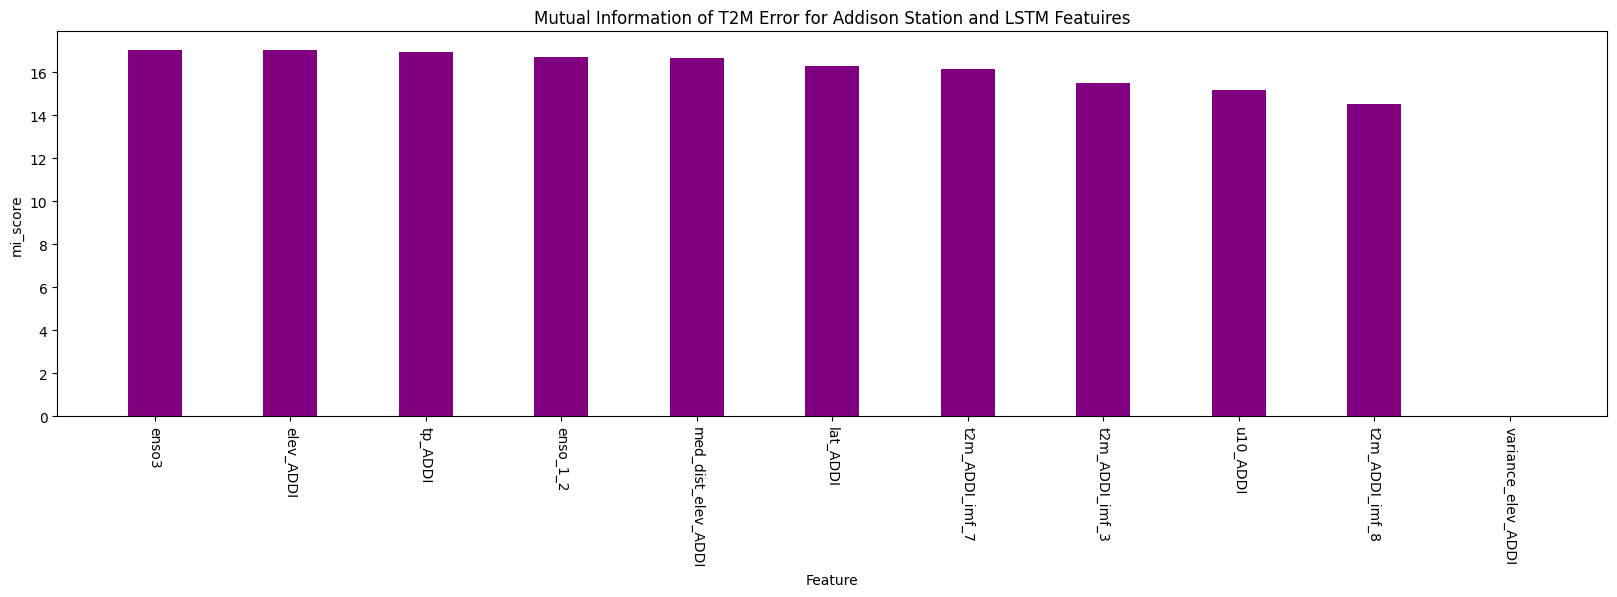

In [46]:
b = 0
e = 30
for i in np.arange(0, len(merged["feature"]), 30):
    fig = plt.figure(figsize=(20, 5))

    # creating the bar plot
    plt.bar(
        merged["feature"].iloc[b:e],
        merged["average"].iloc[b:e],
        color="purple",
        width=0.4,
    )

    plt.xlabel("Feature")
    plt.xticks(rotation=270)
    plt.ylabel("mi_score")
    plt.title("Mutual Information of T2M Error for Addison Station and LSTM Featuires")
    plt.show()
    b += 30
    e += 30